# Titanic - SHAP による説明可能AI (XAI)

このノートブックでは、SHAP（SHapley Additive exPlanations）を使用して、タイタニック生存予測モデルの判断根拠を可視化・分析します。

## 目標
- Random Forestモデルの予測を SHAP で説明
- 特徴量の重要度と影響を可視化
- 個別の予測について「なぜそうなったか」を解釈

## SHAP とは
SHAP（SHapley Additive exPlanations）は、ゲーム理論のシャープレイ値に基づいて、各特徴量がモデルの予測にどれだけ貢献したかを計算する手法です。

**主な特徴:**
- モデルに依存しない説明が可能
- 数学的に厳密な理論に基づく
- 全体的な傾向と個別予測の両方を説明可能

In [1]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib  # 日本語フォント対応

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# SHAP ライブラリ
import shap

# 警告を非表示
import warnings
warnings.filterwarnings('ignore')

# 表示設定
pd.set_option('display.max_columns', None)
%matplotlib inline

# SHAP の JavaScript 可視化を有効化
shap.initjs()

print(f"SHAP version: {shap.__version__}")

SHAP version: 0.49.1


## 1. データの読み込み

In [2]:
# データの読み込み
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

print(f'訓練データサイズ: {train.shape}')
print(f'テストデータサイズ: {test.shape}')

train.head()

訓練データサイズ: (891, 12)
テストデータサイズ: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. 特徴量エンジニアリング

ベースラインモデルと同じ特徴量を作成します。

In [3]:
def feature_engineering(df):
    """
    特徴量エンジニアリングを実施
    """
    df = df.copy()
    
    # 1. 家族サイズ
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    # 2. 単身者フラグ
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    # 3. 名前からタイトルを抽出
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # タイトルを統合
    df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 
                                        'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    
    # 4. 年齢の欠損値をタイトルごとの中央値で補完
    title_age_median = df.groupby('Title')['Age'].transform('median')
    df['Age'] = df['Age'].fillna(title_age_median)
    
    # 5. 年齢をカテゴリ化
    df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100], 
                            labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
    
    # 6. 運賃の欠損値を補完
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    
    # 7. 運賃をカテゴリ化
    df['FareGroup'] = pd.qcut(df['Fare'], q=4, labels=['Low', 'Medium', 'High', 'VeryHigh'], duplicates='drop')
    
    # 8. 乗船港の欠損値を補完
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    
    return df

# 特徴量エンジニアリングを適用
train_processed = feature_engineering(train)
test_processed = feature_engineering(test)

print("特徴量エンジニアリング完了")

特徴量エンジニアリング完了


## 3. データの前処理

In [4]:
def preprocess_data(df, is_train=True):
    """
    モデル学習用にデータを前処理
    """
    df = df.copy()
    
    # 不要なカラムを削除
    drop_columns = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    df = df.drop(columns=drop_columns, errors='ignore')
    
    # カテゴリ変数をOne-Hotエンコーディング
    categorical_features = ['Sex', 'Embarked', 'Title', 'AgeGroup', 'FareGroup']
    df = pd.get_dummies(df, columns=categorical_features, drop_first=True)
    
    # 目的変数を分離
    if is_train and 'Survived' in df.columns:
        y = df['Survived']
        X = df.drop(columns=['Survived'])
        return X, y
    else:
        return df

# 訓練データの前処理
X, y = preprocess_data(train_processed, is_train=True)

# テストデータの前処理
X_test = preprocess_data(test_processed, is_train=False)

# 特徴量を揃える
X, X_test = X.align(X_test, join='left', axis=1, fill_value=0)

print(f"訓練データ特徴量: {X.shape}")
print(f"目的変数: {y.shape}")
print(f"\n特徴量一覧:")
print(X.columns.tolist())

訓練データ特徴量: (891, 21)
目的変数: (891,)

特徴量一覧:
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'AgeGroup_Teen', 'AgeGroup_Adult', 'AgeGroup_Middle', 'AgeGroup_Senior', 'FareGroup_Medium', 'FareGroup_High', 'FareGroup_VeryHigh']


## 4. モデルの訓練

In [5]:
# 訓練データと検証データに分割
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"訓練データ: {X_train.shape}")
print(f"検証データ: {X_valid.shape}")

訓練データ: (712, 21)
検証データ: (179, 21)


In [6]:
# Random Forestモデルの訓練
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# 精度を確認
y_pred = model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)

print(f"検証データの精度: {accuracy:.4f}")
print(f"\n分類レポート:")
print(classification_report(y_valid, y_pred, target_names=['死亡', '生存']))

検証データの精度: 0.8156

分類レポート:
              precision    recall  f1-score   support

          死亡       0.83      0.88      0.85       110
          生存       0.79      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



## 5. SHAP による説明

ここからが本題です！SHAP を使ってモデルの予測を説明していきます。

### 5.1 SHAP Explainer の作成

In [7]:
# TreeExplainer を使用（Random Forest に最適化された高速な説明器）
explainer = shap.TreeExplainer(model)

# SHAP値を計算（検証データに対して）
shap_values = explainer.shap_values(X_valid)

# SHAP値の形状を確認して適切に処理
print(f"SHAP値の元の形状: {np.array(shap_values).shape}")

if isinstance(shap_values, list):
    # リストの場合（2クラス分）
    print(f"クラス0（死亡）のSHAP値: {shap_values[0].shape}")
    print(f"クラス1（生存）のSHAP値: {shap_values[1].shape}")
    shap_values_class1 = shap_values[1]
elif len(shap_values.shape) == 3:
    # 3次元配列の場合 (samples, features, classes)
    print(f"3次元配列を検出しました")
    print(f"生存クラス（インデックス1）のSHAP値を抽出します")
    shap_values_class1 = shap_values[:, :, 1]
else:
    # 2次元配列の場合
    shap_values_class1 = shap_values

print(f"\n使用するSHAP値の形状: {shap_values_class1.shape}")
print(f"期待される形状: (サンプル数={len(X_valid)}, 特徴量数={X_valid.shape[1]})")
print(f"形状チェック: {'OK' if shap_values_class1.shape == (len(X_valid), X_valid.shape[1]) else 'NG'}")

SHAP値の元の形状: (179, 21, 2)
3次元配列を検出しました
生存クラス（インデックス1）のSHAP値を抽出します

使用するSHAP値の形状: (179, 21)
期待される形状: (サンプル数=179, 特徴量数=21)
形状チェック: OK


### 5.2 Summary Plot - 全体的な特徴量の影響

Summary Plot は、すべてのサンプルについて各特徴量の SHAP 値を可視化します。

**読み方:**
- 縦軸: 特徴量（重要度順に並ぶ）
- 横軸: SHAP値（正の値は生存確率を上げる、負の値は下げる）
- 色: 特徴量の値（赤=高い、青=低い）
- 各点: 1人の乗客

**デバッグ情報:**

In [8]:
# デバッグ: SHAP値の形状を確認
print(f"shap_values_class1 の型: {type(shap_values_class1)}")
print(f"shap_values_class1 の形状: {shap_values_class1.shape}")
print(f"X_valid の形状: {X_valid.shape}")
print(f"形状が一致: {shap_values_class1.shape == X_valid.shape}")
print(f"\nshap_values_class1 の最初のサンプル:")
print(shap_values_class1[0])
print(f"\nshap_values_class1 の最初のサンプルの長さ: {len(shap_values_class1[0])}")

shap_values_class1 の型: <class 'numpy.ndarray'>
shap_values_class1 の形状: (179, 21)
X_valid の形状: (179, 21)
形状が一致: True

shap_values_class1 の最初のサンプル:
[-0.04427638 -0.0044125   0.00471698 -0.0008173   0.00175254  0.02204377
  0.0032031  -0.07573825 -0.00142732 -0.00792177 -0.01470726 -0.07658163
 -0.01847151  0.00048478  0.00049853 -0.00071482  0.0013596   0.00015207
 -0.00298583  0.00122803 -0.00707154]

shap_values_class1 の最初のサンプルの長さ: 21


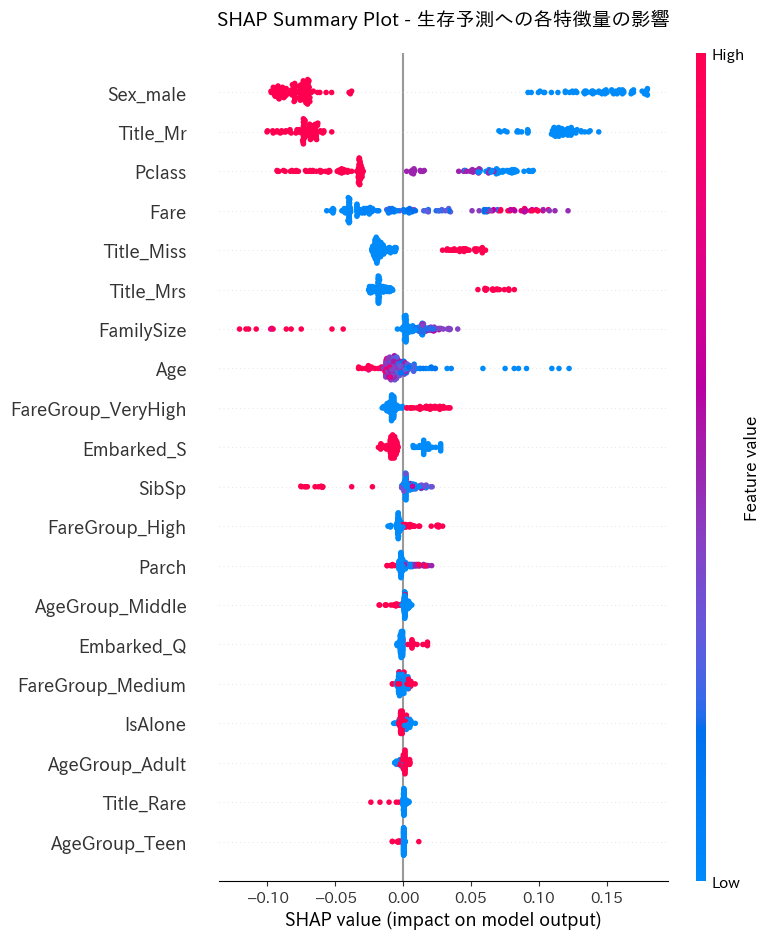

In [9]:
# Summary Plot（生存クラス[1]に対する影響）
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_class1, X_valid, plot_type="dot", show=False)
plt.title('SHAP Summary Plot - 生存予測への各特徴量の影響', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

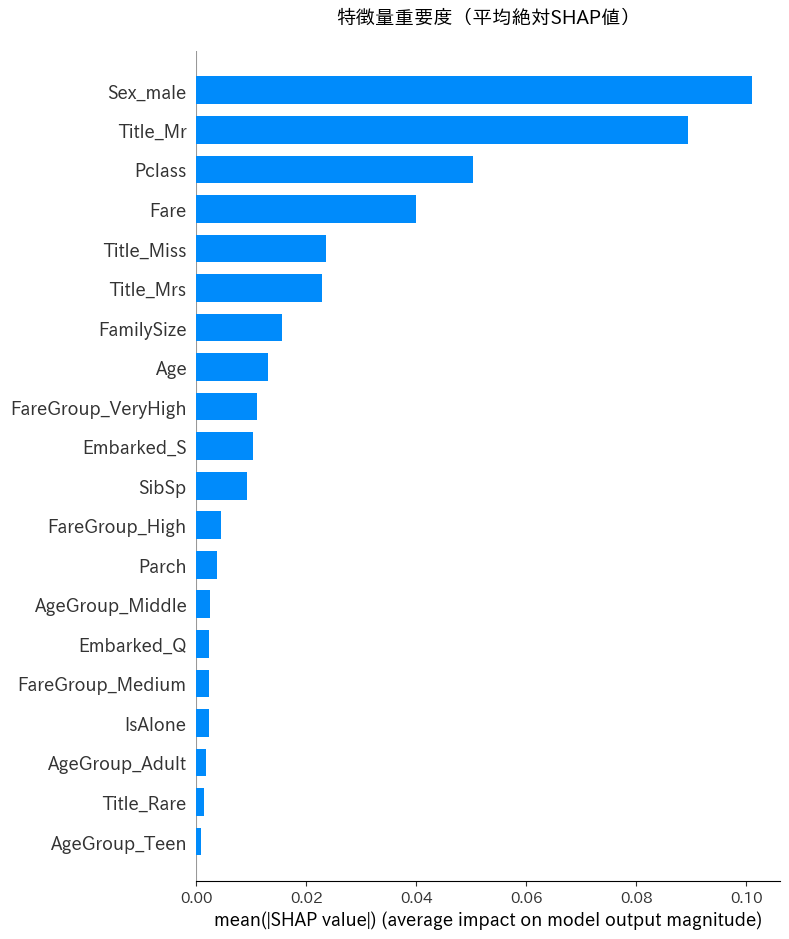

In [10]:
# Bar Plot - 平均絶対SHAP値による特徴量重要度
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_class1, X_valid, plot_type="bar", show=False)
plt.title('特徴量重要度（平均絶対SHAP値）', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

### 5.3 Dependence Plot - 特定特徴量の影響を詳細分析

Dependence Plot は、特定の特徴量の値とSHAP値の関係を可視化します。

**注:** `interaction_index=None` を指定して、自動的な相互作用検出を無効化しています。

<Figure size 1000x600 with 0 Axes>

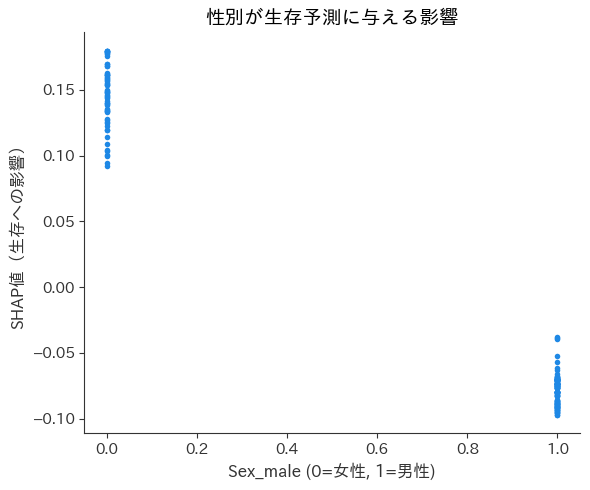

解釈: 男性（1）は生存確率を大きく下げ、女性（0）は生存確率を上げる傾向


In [11]:
# 性別（Sex_male）の影響
plt.figure(figsize=(10, 6))
# interaction_index を None に設定して自動検出を無効化
shap.dependence_plot("Sex_male", shap_values_class1, X_valid, interaction_index=None, show=False)
plt.title('性別が生存予測に与える影響', fontsize=14)
plt.xlabel('Sex_male (0=女性, 1=男性)', fontsize=12)
plt.ylabel('SHAP値（生存への影響）', fontsize=12)
plt.tight_layout()
plt.show()

print("解釈: 男性（1）は生存確率を大きく下げ、女性（0）は生存確率を上げる傾向")

<Figure size 1000x600 with 0 Axes>

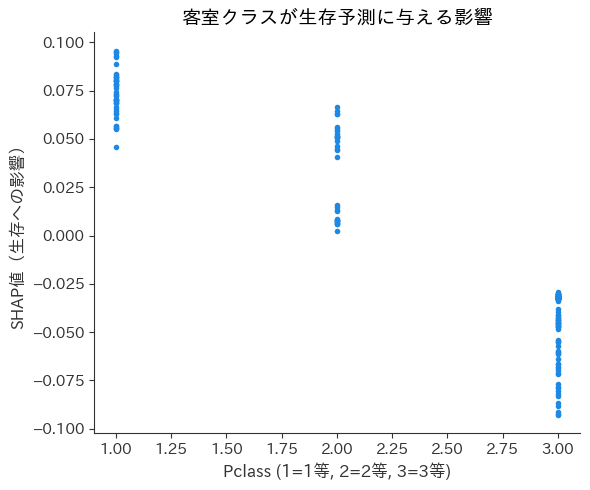

解釈: 1等客室は生存確率を上げ、3等客室は生存確率を下げる傾向


In [12]:
# 客室クラス（Pclass）の影響
plt.figure(figsize=(10, 6))
shap.dependence_plot("Pclass", shap_values_class1, X_valid, interaction_index=None, show=False)
plt.title('客室クラスが生存予測に与える影響', fontsize=14)
plt.xlabel('Pclass (1=1等, 2=2等, 3=3等)', fontsize=12)
plt.ylabel('SHAP値（生存への影響）', fontsize=12)
plt.tight_layout()
plt.show()

print("解釈: 1等客室は生存確率を上げ、3等客室は生存確率を下げる傾向")

<Figure size 1000x600 with 0 Axes>

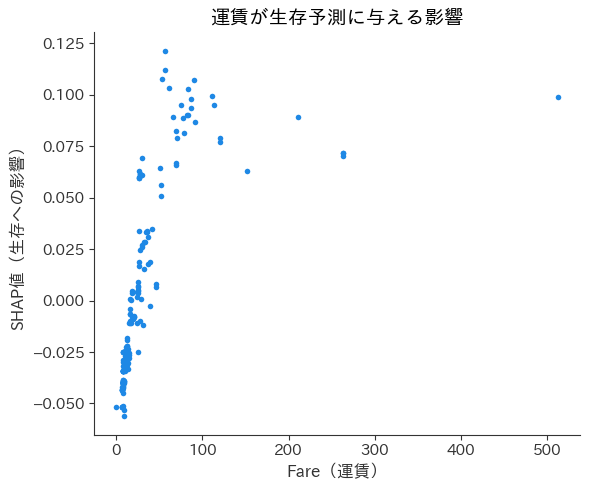

解釈: 高額な運賃は生存確率を上げる傾向（富裕層は良い客室にいた）


In [13]:
# 運賃（Fare）の影響
plt.figure(figsize=(10, 6))
shap.dependence_plot("Fare", shap_values_class1, X_valid, interaction_index=None, show=False)
plt.title('運賃が生存予測に与える影響', fontsize=14)
plt.xlabel('Fare（運賃）', fontsize=12)
plt.ylabel('SHAP値（生存への影響）', fontsize=12)
plt.tight_layout()
plt.show()

print("解釈: 高額な運賃は生存確率を上げる傾向（富裕層は良い客室にいた）")

### 5.4 個別予測の説明 - Force Plot

Force Plot は、個々の予測について「どの特徴量がどれだけ影響したか」を可視化します。

**読み方:**
- 基準値（base value）: 全体の平均予測確率
- 赤い矢印: 生存確率を上げる特徴量
- 青い矢印: 生存確率を下げる特徴量
- 最終値（output value）: この乗客の予測確率

In [14]:
# 検証データから生存者と死亡者の例を選択
survived_idx = X_valid[y_valid == 1].index[0]
deceased_idx = X_valid[y_valid == 0].index[0]

print(f"生存者の例: インデックス {survived_idx}")
print(f"死亡者の例: インデックス {deceased_idx}")

生存者の例: インデックス 553
死亡者の例: インデックス 565


【死亡者の例】
実際の結果: 死亡
予測確率: 0.165

乗客情報:
  性別: male
  年齢: 24歳
  客室クラス: 3等
  運賃: $24.15
  家族サイズ: 3人
  乗船港: S


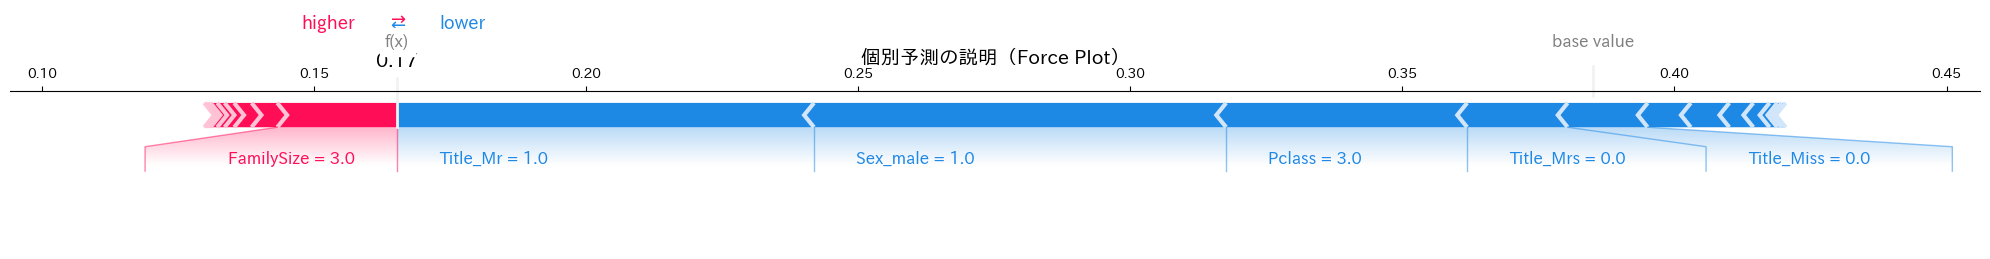

In [15]:
# 生存者の例 - Force Plot
sample_idx = 0  # 検証データの最初のサンプル

# 元のデータを確認
original_data = train_processed.loc[X_valid.index[sample_idx]]
print("=" * 60)
print("【生存者の例】" if y_valid.iloc[sample_idx] == 1 else "【死亡者の例】")
print("=" * 60)
print(f"実際の結果: {'生存' if y_valid.iloc[sample_idx] == 1 else '死亡'}")
print(f"予測確率: {model.predict_proba(X_valid.iloc[[sample_idx]])[0][1]:.3f}")
print(f"\n乗客情報:")
print(f"  性別: {original_data['Sex']}")
print(f"  年齢: {original_data['Age']:.0f}歳")
print(f"  客室クラス: {original_data['Pclass']}等")
print(f"  運賃: ${original_data['Fare']:.2f}")
print(f"  家族サイズ: {original_data['FamilySize']}人")
print(f"  乗船港: {original_data['Embarked']}")

# Force Plot
shap.force_plot(
    explainer.expected_value[1],
    shap_values_class1[sample_idx],
    X_valid.iloc[sample_idx],
    matplotlib=True,
    show=False
)
plt.title('個別予測の説明（Force Plot）', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

【死亡者の例】
実際の結果: 死亡
予測確率: 0.165

乗客情報:
  性別: male
  年齢: 24歳
  客室クラス: 3等
  運賃: $24.15
  家族サイズ: 3人
  乗船港: S


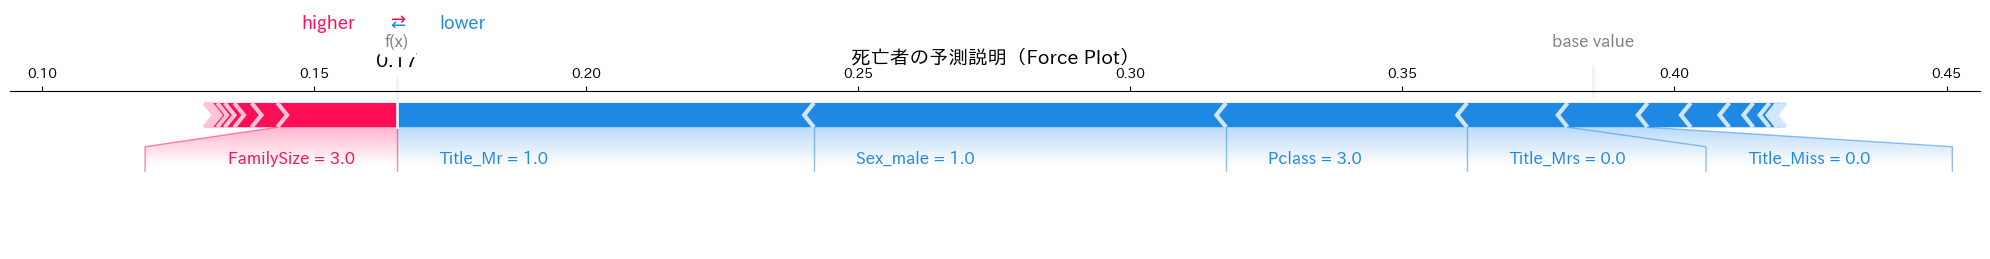

In [16]:
# 死亡者の例 - Force Plot
# 死亡者を検索
deceased_samples = [i for i in range(len(y_valid)) if y_valid.iloc[i] == 0]
sample_idx = deceased_samples[0] if len(deceased_samples) > 0 else 0

# 元のデータを確認
original_data = train_processed.loc[X_valid.index[sample_idx]]
print("=" * 60)
print("【死亡者の例】")
print("=" * 60)
print(f"実際の結果: {'生存' if y_valid.iloc[sample_idx] == 1 else '死亡'}")
print(f"予測確率: {model.predict_proba(X_valid.iloc[[sample_idx]])[0][1]:.3f}")
print(f"\n乗客情報:")
print(f"  性別: {original_data['Sex']}")
print(f"  年齢: {original_data['Age']:.0f}歳")
print(f"  客室クラス: {original_data['Pclass']}等")
print(f"  運賃: ${original_data['Fare']:.2f}")
print(f"  家族サイズ: {original_data['FamilySize']}人")
print(f"  乗船港: {original_data['Embarked']}")

# Force Plot
shap.force_plot(
    explainer.expected_value[1],
    shap_values_class1[sample_idx],
    X_valid.iloc[sample_idx],
    matplotlib=True,
    show=False
)
plt.title('死亡者の予測説明（Force Plot）', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

### 5.5 Waterfall Plot - 個別予測の詳細な寄与度

Waterfall Plot は、基準値から最終予測値までの各特徴量の寄与を段階的に表示します。

【生存者の予測プロセス】


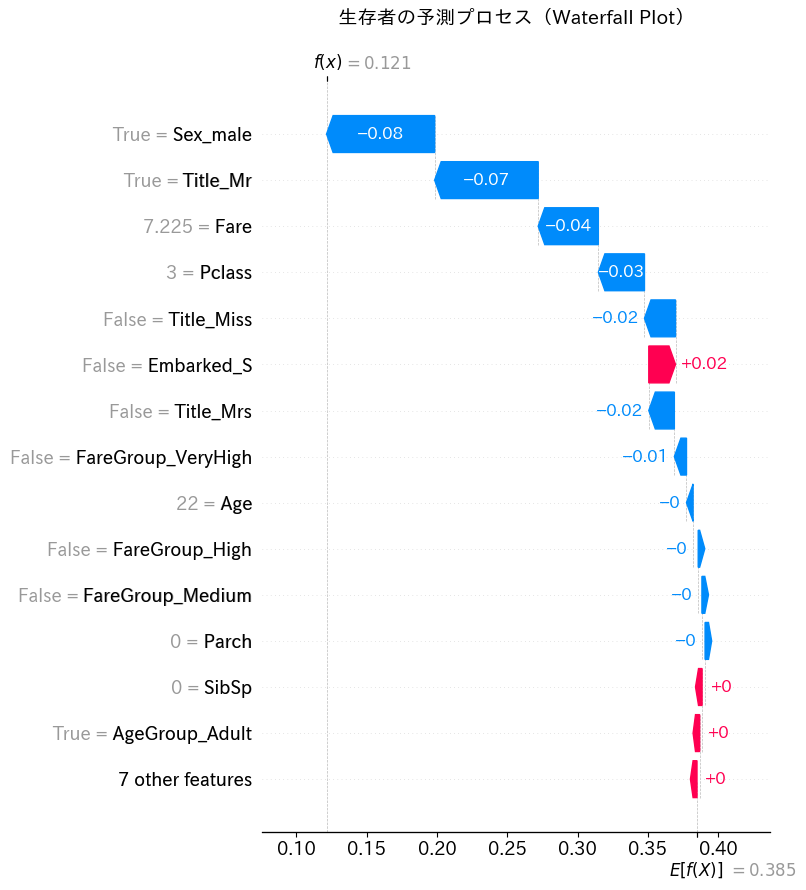

In [17]:
# 生存者の Waterfall Plot
survived_samples = [i for i in range(len(y_valid)) if y_valid.iloc[i] == 1]
sample_idx = survived_samples[0] if len(survived_samples) > 0 else 0

# SHAP Explanation オブジェクトを作成
explanation = shap.Explanation(
    values=shap_values_class1[sample_idx],
    base_values=explainer.expected_value[1],
    data=X_valid.iloc[sample_idx].values,
    feature_names=X_valid.columns.tolist()
)

print("【生存者の予測プロセス】")
shap.waterfall_plot(explanation, max_display=15, show=False)
plt.title('生存者の予測プロセス（Waterfall Plot）', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

【死亡者の予測プロセス】


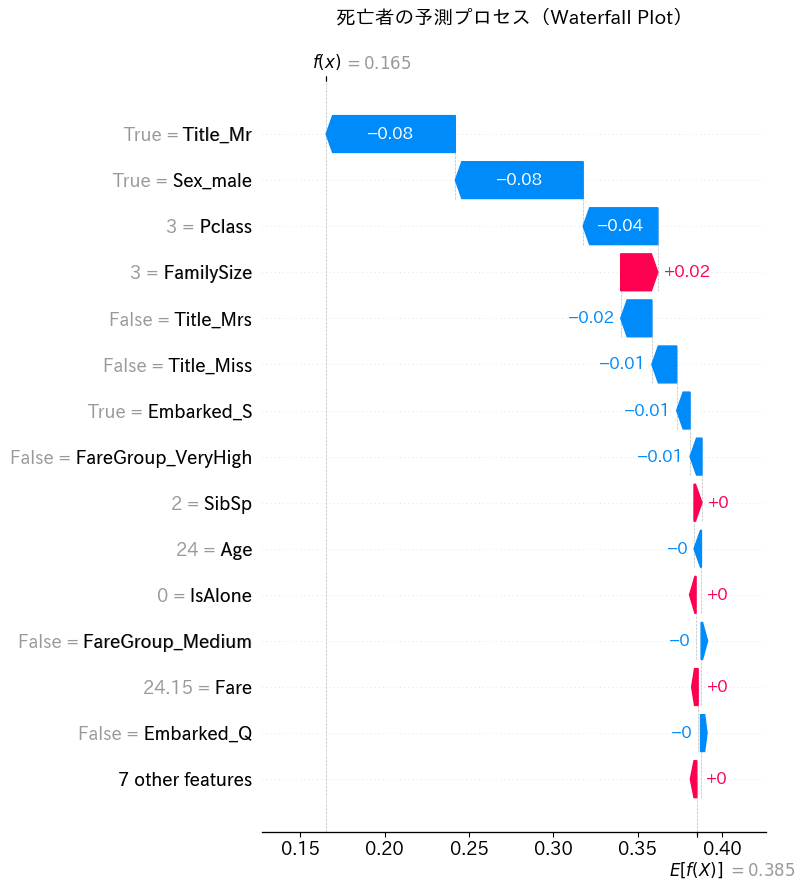

In [18]:
# 死亡者の Waterfall Plot
deceased_samples = [i for i in range(len(y_valid)) if y_valid.iloc[i] == 0]
sample_idx = deceased_samples[0] if len(deceased_samples) > 0 else 0

# SHAP Explanation オブジェクトを作成
explanation = shap.Explanation(
    values=shap_values_class1[sample_idx],
    base_values=explainer.expected_value[1],
    data=X_valid.iloc[sample_idx].values,
    feature_names=X_valid.columns.tolist()
)

print("【死亡者の予測プロセス】")
shap.waterfall_plot(explanation, max_display=15, show=False)
plt.title('死亡者の予測プロセス（Waterfall Plot）', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

### 5.6 複数サンプルの Force Plot

複数の乗客の予測を一度に可視化することもできます。

In [19]:
# 最初の100人の Force Plot（インタラクティブ版）
# 注意: Jupyter Notebook でのみ動作します
shap.force_plot(
    explainer.expected_value[1],
    shap_values_class1[:100],
    X_valid.iloc[:100]
)

## 6. SHAP による知見のまとめ

SHAP分析から得られた主な知見をまとめます。

In [20]:
# 特徴量重要度のまとめ
feature_importance = pd.DataFrame({
    'feature': X_valid.columns,
    'mean_abs_shap': np.abs(shap_values_class1).mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False)

print("=" * 80)
print("SHAP による特徴量重要度 Top 10")
print("=" * 80)
print(feature_importance.head(10).to_string(index=False))
print("\n" + "=" * 80)
print("\n【主な知見】")
print("-" * 80)
print("1. 性別（Sex_male）が最も重要")
print("   → 女性は生存確率が高く、男性は低い（'Women and children first' の原則）")
print("\n2. タイトル（Mr, Miss, Mrs など）が重要")
print("   → 社会的地位や年齢・性別の複合的な影響を反映")
print("\n3. 年齢が重要")
print("   → 子供は優先的に救助された")
print("\n4. 客室クラス（Pclass）と運賃（Fare）")
print("   → 富裕層（1等客室）は生存確率が高い")
print("\n5. 家族サイズ")
print("   → 適度な家族がいる方が生存確率が高い傾向")
print("=" * 80)

SHAP による特徴量重要度 Top 10
           feature  mean_abs_shap
          Sex_male       0.101090
          Title_Mr       0.089409
            Pclass       0.050281
              Fare       0.040034
        Title_Miss       0.023602
         Title_Mrs       0.022868
        FamilySize       0.015513
               Age       0.013064
FareGroup_VeryHigh       0.011031
        Embarked_S       0.010388


【主な知見】
--------------------------------------------------------------------------------
1. 性別（Sex_male）が最も重要
   → 女性は生存確率が高く、男性は低い（'Women and children first' の原則）

2. タイトル（Mr, Miss, Mrs など）が重要
   → 社会的地位や年齢・性別の複合的な影響を反映

3. 年齢が重要
   → 子供は優先的に救助された

4. 客室クラス（Pclass）と運賃（Fare）
   → 富裕層（1等客室）は生存確率が高い

5. 家族サイズ
   → 適度な家族がいる方が生存確率が高い傾向


## 7. インタラクティブな予測説明

任意の乗客について予測を説明できる関数を作成します。

任意の乗客の予測を説明します

乗客 #0 の予測説明

【基本情報】
  名前: Davies, Mr. Alfred J
  性別: male
  年齢: 24歳
  客室クラス: 3等
  運賃: $24.15
  家族サイズ: 3人
  乗船港: S

【予測結果】
  実際の結果: 死亡
  予測: 死亡
  生存確率: 16.5%
  死亡確率: 83.5%
  予測は 正解

【生存確率に影響した要因 Top 5】
  Title_Mr: 1.00 → SHAP値 -0.077 (下降)
  Sex_male: 1.00 → SHAP値 -0.076 (下降)
  Pclass: 3.00 → SHAP値 -0.044 (下降)
  FamilySize: 3.00 → SHAP値 +0.022 (上昇)
  Title_Mrs: 0.00 → SHAP値 -0.018 (下降)

【予測プロセスの可視化】


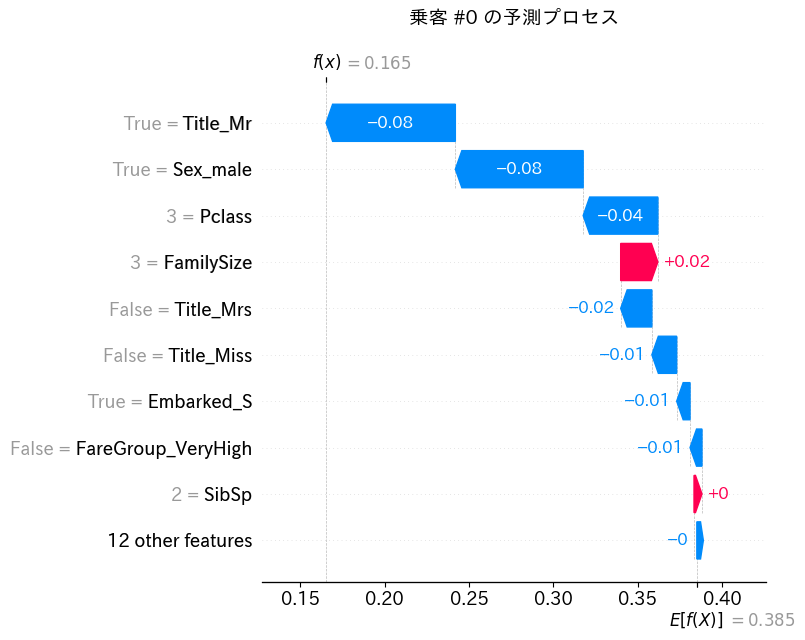

In [21]:
def explain_prediction(passenger_index):
    """
    指定した乗客の予測を詳しく説明する関数
    """
    # 検証データ内のインデックスを取得
    if passenger_index >= len(X_valid):
        print(f"エラー: インデックスは0から{len(X_valid)-1}の範囲で指定してください")
        return
    
    # 元のデータを取得
    original_data = train_processed.loc[X_valid.index[passenger_index]]
    
    # 予測
    prediction_proba = model.predict_proba(X_valid.iloc[[passenger_index]])[0]
    prediction = model.predict(X_valid.iloc[[passenger_index]])[0]
    actual = y_valid.iloc[passenger_index]
    
    # 表示
    print("=" * 80)
    print(f"乗客 #{passenger_index} の予測説明")
    print("=" * 80)
    print(f"\n【基本情報】")
    print(f"  名前: {original_data['Name']}")
    print(f"  性別: {original_data['Sex']}")
    print(f"  年齢: {original_data['Age']:.0f}歳")
    print(f"  客室クラス: {original_data['Pclass']}等")
    print(f"  運賃: ${original_data['Fare']:.2f}")
    print(f"  家族サイズ: {original_data['FamilySize']}人")
    print(f"  乗船港: {original_data['Embarked']}")
    
    print(f"\n【予測結果】")
    print(f"  実際の結果: {'生存' if actual == 1 else '死亡'}")
    print(f"  予測: {'生存' if prediction == 1 else '死亡'}")
    print(f"  生存確率: {prediction_proba[1]:.1%}")
    print(f"  死亡確率: {prediction_proba[0]:.1%}")
    print(f"  予測は {'正解' if prediction == actual else '不正解'}")
    
    # SHAP値の上位要因
    shap_contribution = pd.DataFrame({
        'feature': X_valid.columns,
        'value': X_valid.iloc[passenger_index].values,
        'shap_value': shap_values_class1[passenger_index]
    }).sort_values('shap_value', key=abs, ascending=False)
    
    print(f"\n【生存確率に影響した要因 Top 5】")
    for idx, row in shap_contribution.head(5).iterrows():
        direction = "上昇" if row['shap_value'] > 0 else "下降"
        print(f"  {row['feature']}: {row['value']:.2f} → SHAP値 {row['shap_value']:+.3f} ({direction})")
    
    # Waterfall Plot
    explanation = shap.Explanation(
        values=shap_values_class1[passenger_index],
        base_values=explainer.expected_value[1],
        data=X_valid.iloc[passenger_index].values,
        feature_names=X_valid.columns.tolist()
    )
    
    print("\n【予測プロセスの可視化】")
    shap.waterfall_plot(explanation, max_display=10, show=False)
    plt.title(f'乗客 #{passenger_index} の予測プロセス', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()
    print("=" * 80)

# 使用例
print("任意の乗客の予測を説明します\n")
explain_prediction(0)  # 最初の乗客

乗客 #5 の予測説明

【基本情報】
  名前: de Messemaeker, Mrs. Guillaume Joseph (Emma)
  性別: female
  年齢: 36歳
  客室クラス: 3等
  運賃: $17.40
  家族サイズ: 2人
  乗船港: S

【予測結果】
  実際の結果: 生存
  予測: 生存
  生存確率: 55.1%
  死亡確率: 44.9%
  予測は 正解

【生存確率に影響した要因 Top 5】
  Sex_male: 0.00 → SHAP値 +0.127 (上昇)
  Title_Mr: 0.00 → SHAP値 +0.111 (上昇)
  Pclass: 3.00 → SHAP値 -0.088 (下降)
  Title_Mrs: 1.00 → SHAP値 +0.055 (上昇)
  AgeGroup_Middle: 1.00 → SHAP値 -0.018 (下降)

【予測プロセスの可視化】


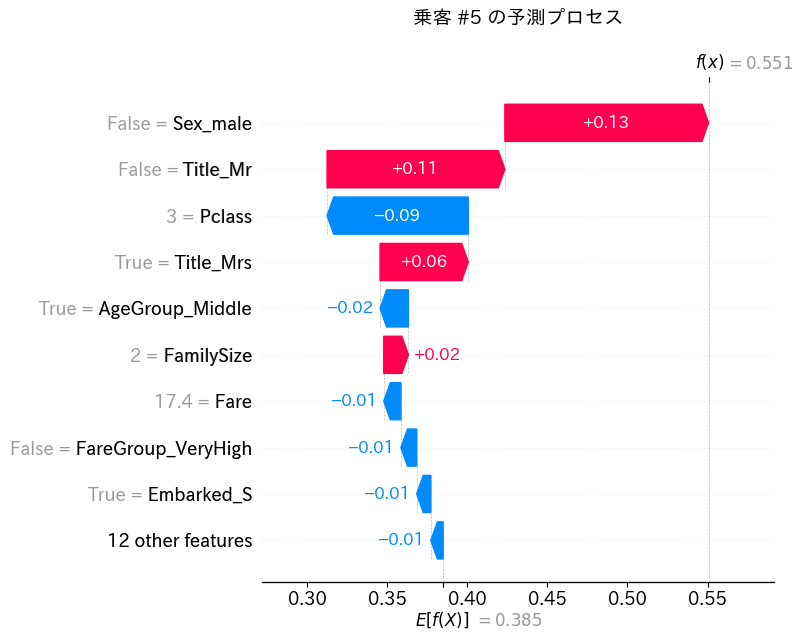

In [22]:
# 他の乗客も試してみる
explain_prediction(5)  # 別の乗客


予測が間違っているケース数: 33件
最初の間違い例を説明します:

乗客 #2 の予測説明

【基本情報】
  名前: Leeni, Mr. Fahim ("Philip Zenni")
  性別: male
  年齢: 22歳
  客室クラス: 3等
  運賃: $7.22
  家族サイズ: 1人
  乗船港: C

【予測結果】
  実際の結果: 生存
  予測: 死亡
  生存確率: 12.1%
  死亡確率: 87.9%
  予測は 不正解

【生存確率に影響した要因 Top 5】
  Sex_male: 1.00 → SHAP値 -0.077 (下降)
  Title_Mr: 1.00 → SHAP値 -0.074 (下降)
  Fare: 7.22 → SHAP値 -0.043 (下降)
  Pclass: 3.00 → SHAP値 -0.033 (下降)
  Title_Miss: 0.00 → SHAP値 -0.022 (下降)

【予測プロセスの可視化】


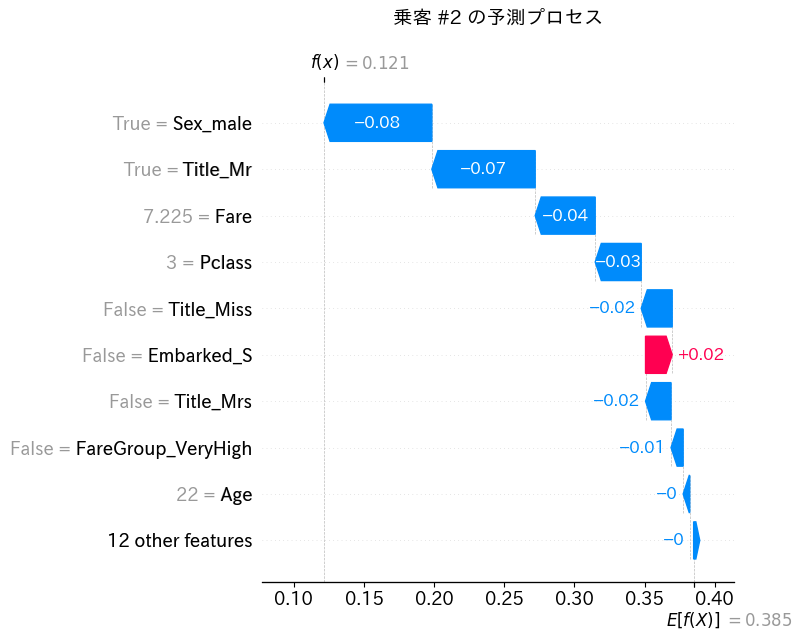

In [23]:
# 予測が間違っているケースを探して説明
wrong_predictions = [i for i in range(len(y_valid)) if model.predict(X_valid.iloc[[i]])[0] != y_valid.iloc[i]]

if len(wrong_predictions) > 0:
    print(f"\n予測が間違っているケース数: {len(wrong_predictions)}件")
    print(f"最初の間違い例を説明します:\n")
    explain_prediction(wrong_predictions[0])
else:
    print("すべての予測が正解でした！")

## 8. まとめと次のステップ

### このノートブックで学んだこと

1. **SHAP の基本的な使い方**
   - `TreeExplainer` を使った高速な SHAP 値計算
   - 各種可視化手法の活用

2. **全体的な傾向の理解**
   - Summary Plot で特徴量の重要度を把握
   - Dependence Plot で特定特徴量の影響を分析

3. **個別予測の説明**
   - Force Plot で予測の根拠を視覚化
   - Waterfall Plot で段階的な寄与を理解

### XAI の実務での活用例

- **モデルのデバッグ**: 予測ミスの原因を特定
- **特徴量エンジニアリング**: どの特徴量が効いているか確認
- **ステークホルダーへの説明**: 予測の根拠を分かりやすく提示
- **公平性の確認**: 性別・年齢などの影響が適切か検証

### 次のステップ

1. **他の XAI 手法を試す**
   - LIME（Local Interpretable Model-agnostic Explanations）
   - Permutation Importance
   - Partial Dependence Plot (PDP)

2. **他のモデルで SHAP を使う**
   - XGBoost / LightGBM
   - ニューラルネットワーク（DeepExplainer）
   - 線形モデル（LinearExplainer）

3. **より高度な分析**
   - 特徴量間の相互作用を分析
   - サブグループごとの傾向を比較
   - 時系列データでの SHAP 活用

In [24]:
# 参考リンク
print("=" * 80)
print("参考リソース")
print("=" * 80)
print("\nSHAP 公式ドキュメント:")
print("  https://shap.readthedocs.io/")
print("\nSHAP GitHub:")
print("  https://github.com/slundberg/shap")
print("\n論文:")
print("  A Unified Approach to Interpreting Model Predictions (NIPS 2017)")
print("  https://arxiv.org/abs/1705.07874")
print("=" * 80)

参考リソース

SHAP 公式ドキュメント:
  https://shap.readthedocs.io/

SHAP GitHub:
  https://github.com/slundberg/shap

論文:
  A Unified Approach to Interpreting Model Predictions (NIPS 2017)
  https://arxiv.org/abs/1705.07874
